In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import re
!pip install pymorphy2
from pymorphy2 import MorphAnalyzer
from functools import lru_cache
from nltk.corpus import stopwords

from multiprocessing import Pool
from tqdm import tqdm

import nltk
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

np.random.seed(42)
random.seed(42)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 1.1 MB/s 
     |████████████████████████████████| 8.2 MB 6.8 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13723 sha256=d19031665343a9e2dad060c9e353bd96f37d00666f569b7b61591ab1d88e0b5e
  Stored in directory: /root/.cache/pip/wheels/56/ea/58/ead137b087d9e326852a851351d1debf4ada529b6ac0ec4e8c
Successfully built docopt


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv('train_dl.csv')
df

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,31.12.2017 18:20
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,22.11.2019 22:42
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,27.12.2018 23:20
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,05.02.2020 16:40
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,26.02.2016 15:48
...,...,...,...,...
349995,investtorgbank,Хочу поделиться своим положительными опытом от...,5.0,17.12.2012 22:57
349996,unicreditbank,Добрый день!Хочу оставить отзыв по банку Юникр...,1.0,01.02.2021 11:44
349997,locko-bank,Доброго дня! Обратился в Локо Банк с просьбой ...,5.0,24.04.2020 11:39
349998,tcs,"Просрочил платеж на 5 дней, а мне уже взыскани...",NaN,24.11.2020 23:39


# Some EDA

Сразу видим, что в столбце с целевой переменной (`grades`) есть пропуски. В этом ноутбуке будем обучаться на отзывах, для которых есть информация о значении таргета. **Но это не единственный подход. Подумайте, что ещё можно сделать**

Посмотрим, есть ли пропуски в признаках

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350000 entries, 0 to 349999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   bank    350000 non-null  object 
 1   feeds   350000 non-null  object 
 2   grades  240250 non-null  float64
 3   date    350000 non-null  object 
dtypes: float64(1), object(3)
memory usage: 10.7+ MB


Сразу преобразуем столбец с меткой времени к соответствующему формату. И удалим строчки с пропусками в таргете

In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y %H:%M')
df = df.dropna()
df = df.astype({'grades': 'int32'})
df

,bank,feeds,grades,date
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5,2017-12-31 18:20:00
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1,2019-11-22 22:42:00
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1,2018-12-27 23:20:00
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2,2020-02-05 16:40:00
5,pochtabank,08.02.2018 я оформил кредит наличными в отделе...,1,2018-03-21 18:03:00
...,...,...,...,...
349992,sberbank,"Являемся зарплатниками Сбербанка, поэтому с вы...",2,2018-03-30 20:25:00
349994,vtb,Открываю уже не первый расчетный счет в различ...,1,2020-01-19 03:05:00
349995,investtorgbank,Хочу поделиться своим положительными опытом от...,5,2012-12-17 22:57:00
349996,unicreditbank,Добрый день!Хочу оставить отзыв по банку Юникр...,1,2021-02-01 11:44:00


Посмотрим на распределение числа отзывов по банкам

In [ ]:
feeds_by_bank_count = df.bank.value_counts()
feeds_by_bank_count

sberbank            38894
vtb                 25336
tcs                 20850
sovcombank          12273
fk_otkritie         12254
                    ...  
baltinvestbank        159
metallinvestbank      157
bystrobank            145
rnbank                133
primsotsbank          123
Name: bank, Length: 69, dtype: int64

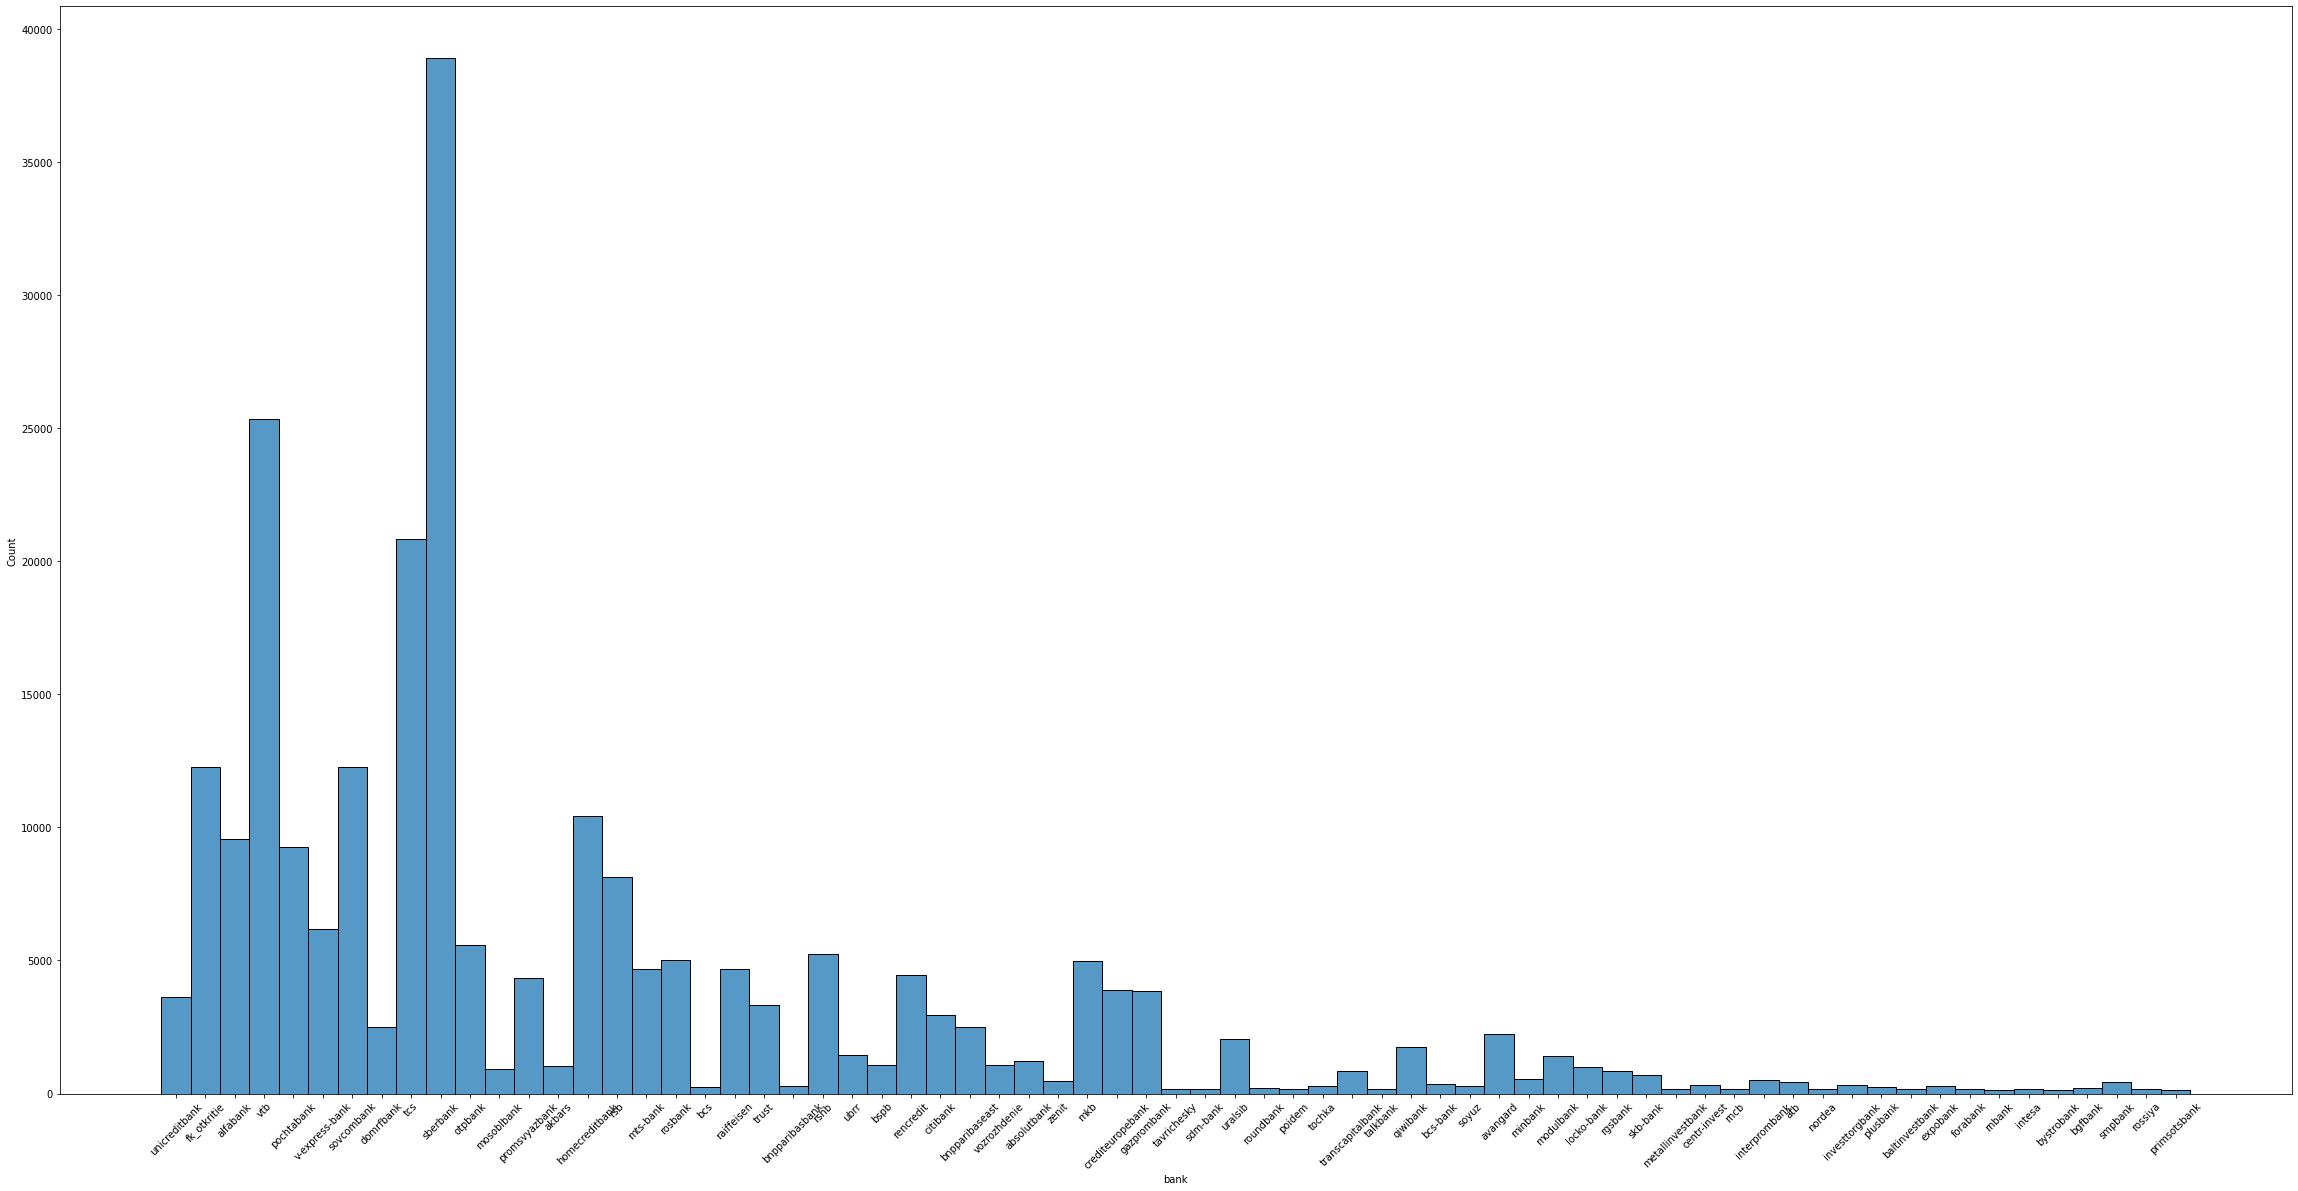

In [ ]:
plt.figure(figsize=(40,20))
sns.histplot(data=df.sort_values(by='bank'),
             x=df.bank, )
plt.xticks(rotation=45)
plt.show()

Глянем на распределение клиентских оценок

In [ ]:
df.grades.value_counts().sort_index()

1    129814
2     25803
3     11131
4      7094
5     66408
Name: grades, dtype: int64

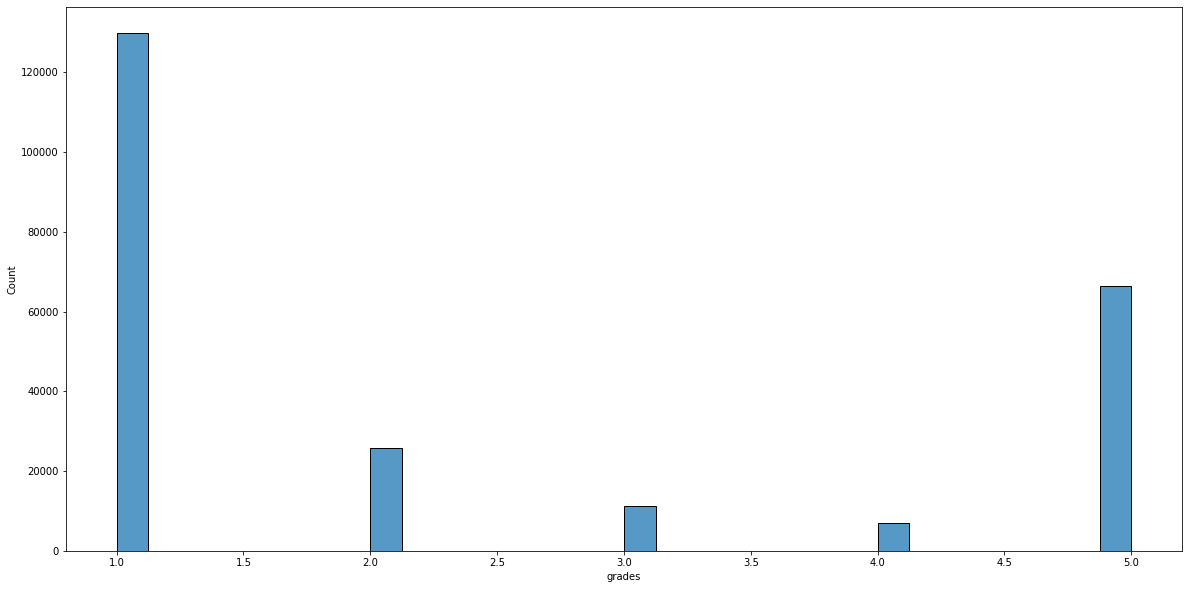

In [ ]:
plt.figure(figsize=(20, 10))
sns.histplot(data=df,
             x=df.grades, )
plt.show()

Также нас интересуют длины отзывов

In [ ]:
df['sym_len'] = df.feeds.apply(len)
df['word_len'] = df.feeds.apply(lambda x: len(x.split()))

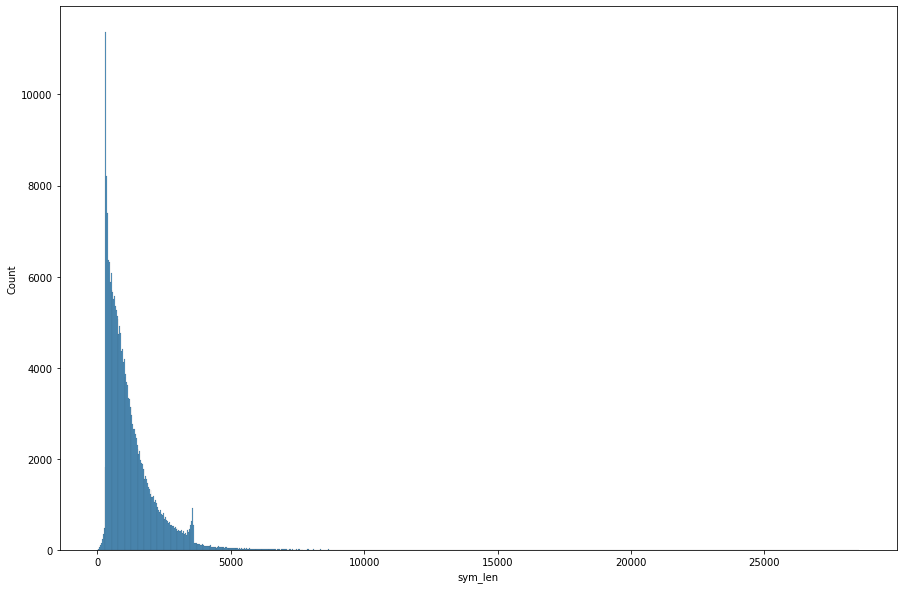

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.sym_len)
plt.show()

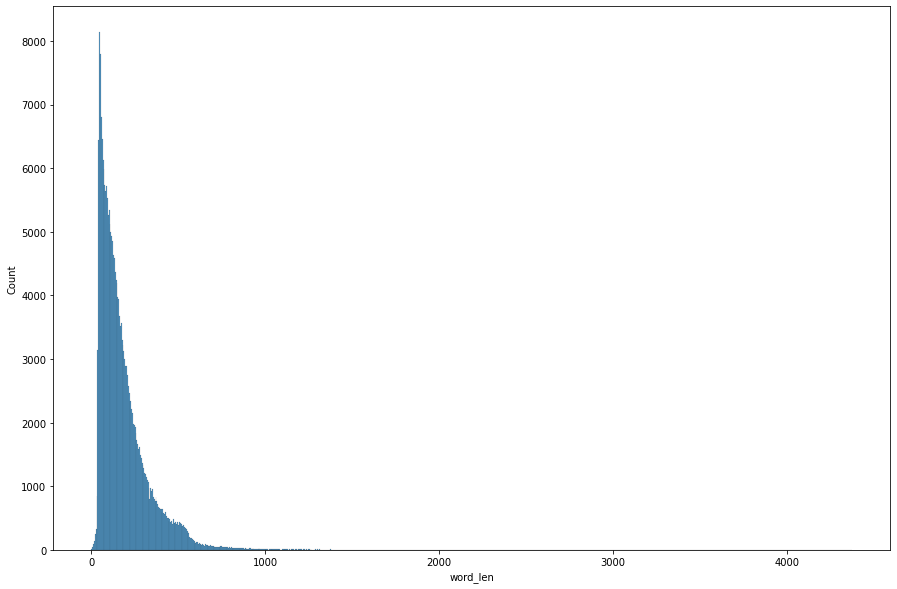

In [ ]:
plt.figure(figsize=(15, 10))
sns.histplot(data=df.word_len)
plt.show()

Обратите внимание, у распределений очень длинные хвосты

# Baseline (tf-idf + logreg)

Подготавливаем тексты отзывов (взято из ноутбука второго занятия 😃)

In [ ]:
m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian')
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)

    return ' '.join(remove_stopwords(lemmas))

In [ ]:
with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, df['feeds']), total=len(df)))

df['lemmas'] = lemmas
df.sample(5)

100%|██████████| 240250/240250 [1:45:38<00:00, 37.90it/s]


,bank,feeds,grades,date,sym_len,word_len,lemmas
70106,bcs-bank,Уважаемый банк БКС! С первых дней обслуживания...,1,2021-01-31 01:10:00,1583,219,уважаемый банк первый день обслуживание сравни...
293909,sberbank,Ситуация на текущий момент 08.02.15. 21.00.С м...,1,2015-02-08 21:03:00,3124,435,ситуация текущий момент социальный банковский ...
295466,mkb,В конце июля я уже писала по поводу навязывани...,1,2016-09-07 21:10:00,1295,203,конец июль писать повод навязывание договор ст...
277828,vtb,"Сегодня в 11:43 мне позвонил сотрудник КЦ, кот...",1,2020-04-02 21:12:00,958,154,сегодня позвонить сотрудник который сообщить о...
221435,alfabank,Добрый день.В августе оформил себе карту Alfa-...,1,2019-01-29 05:55:00,854,135,добрый день август оформить карта alfa travel ...


Будем обучаться исключительно на текстах отзывов (признаки `bank`и `date` не используем от слова совсем -- **мы не используем, а вы в своих решениях попробуйте**)

In [ ]:
y_train = df.grades
y_train = y_train.reset_index().drop(columns='index')
del df # высвободим оперативу, она нам не помешает

Обучимся на всех объектах, а потом сделаем предсказание на тесте из соревнования. Ни больше, ни меньше

In [ ]:
%%time
vec = TfidfVectorizer() # используем только униграммы
bow = vec.fit_transform(lemmas)
clf = LogisticRegression(random_state=42, max_iter=500, warm_start=True)


CPU times: user 23.6 s, sys: 247 ms, total: 23.9 s
Wall time: 23.9 s


In [ ]:
# небольшой трюк: будем обучаться частями
ran = np.arange(y_train.shape[0])
inds = np.array_split(ran, 100) # разобъем на 100 частей
# и подмешаем к каждому куску случайных объектов
inds = [np.concatenate((chunk, np.array(random.sample(list(ran), k=5_000))), axis=None) for chunk in inds]

for chunk in tqdm(inds):
    clf.fit(bow[chunk, :], y_train.iloc[chunk])


100%|██████████| 100/100 [35:41<00:00, 21.42s/it]


Загрузим тест. Предобработаем отзывы в нем и сделаем предсказания

In [ ]:
test = pd.read_csv('new_test_dl.csv', index_col=0)
test

,bank,feeds,date
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00
...,...,...,...
34109,alfabank,"Никогда не думал, что Альфа банк такой ужасный...",23.06.2019 12:40
34110,v-express-bank,Добрый день. Даааа ужжжж... всегда выбирала им...,20.12.2013 3:46
34111,rsb,Приходиться повторно писать об отношении этого...,13.11.2011 17:20
34112,rosbank,"Я долго сотрудничаю с Росбанком, не один креди...",28.02.2017 9:24


In [ ]:
with Pool(4) as p:
    lemmas_test = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))


100%|██████████| 34114/34114 [15:32<00:00, 36.60it/s]


In [ ]:
pred = clf.predict(vec.transform(lemmas_test))
pred

array([1, 1, 5, ..., 1, 1, 1])

In [ ]:
sol = pd.DataFrame({'inds': test.index,
                    'grades': pred})
sol

,inds,grades
0,0,1
1,1,1
2,2,5
3,3,1
4,4,1
...,...,...
34109,34109,1
34110,34110,1
34111,34111,1
34112,34112,1


In [ ]:
sol.to_csv('new_baseline_DL.csv', index=False)

Кстати, если обратите внимание на содержимое вектора предсказанных классов, то наверняка заметите, что модель предсказывает только классы 1 и 5, редко -- 2 и 3 и вообще никогда класс 4. Отчасти это логично -- наблюдается сильный дисбаланс классов. Но этот недочет неплохо бы исправить в ваших решениях

In [ ]:
unique, counts = np.unique(pred, return_counts=True)
np.asarray((unique, counts)).T

array([[    1, 24755],
       [    2,    84],
       [    3,     2],
       [    5,  9273]])